In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install zemberek-python
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import emoji
from zemberek import TurkishTokenizer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
dataset = pd.read_excel("drive/MyDrive/yapayzeka/tubitak/dataset.xlsx")
dataset.head()

,Haberler,Sonuc
0,Kanada-Fas maçında TRT spikerinin devre arasın...,True
1,Bir öğrencinin eksi netle Cumhuriyet Üniversit...,True
2,Taksim saldırısıyla ilgili önergenin AK Parti ...,True
3,Fotoğrafın 19 cm ile dünyanın en uzun burunlu ...,True
4,Ayın arkasında Satürn’ün belirdiği videonun ge...,True


In [33]:
dataset.shape

(1568, 2)

In [34]:
f = open("drive/MyDrive/yapayzeka/tubitak/turkce-stop-words.txt", "r")
turKStopWords=[i[:-1] for i in f]

In [41]:
for i in range(0,dataset.shape[0]):
  tokenizer = TurkishTokenizer.DEFAULT
  cumle = "".join(v for v in dataset.iloc[i,0] if v not in string.punctuation).lower() # Noktalama işaretlerinin kaldırılması ve karakterlerin küçük hale çevrilmesi
  cumle = re.sub(r'\d', '', cumle) # sayısal ifadelerin metinden kaldırılması
  cumle = re.sub('https\S+', '', cumle) #linkelerin metinden kaldırılması 
  html_pattern = r'<.*?>' 
  cumle = re.sub(pattern=html_pattern, repl=' ', string=cumle) #html etiketlerinin metinden kaldırılması
  deneme = emoji.emoji_list(cumle)
  for j in range(len(deneme)-1,-1,-1):
     deger=deneme[j]['match_start'] # j. emoji hangi indiste o indisi al
     cumle=cumle.replace(cumle[deger]," ") #o indisteki emojiyi kaldır
  tokens = tokenizer.tokenize(cumle)
  tokens = [w.content for w in tokens if not str(w.content) in set(stopwords.words("turkish"))] #Token durak kelimeler içerisinde yoksa listeye eklensin
  tokens= [i for i in tokens if i not in turKStopWords and len(i)>=2] # Ekstradan eklediğimiz durak kelimlerin içinde olmayan ve karakter sayısı 2 den fazla olanlar eklenir.
  duzenlenenCumle=" ".join(tokens) #Tokenler birleştirilir.
  dataset.iloc[i,0]=duzenlenenCumle #dateset güncellenir



In [52]:
meetin="merhaba nasılsın 😄🙃😋"
deneme = emoji.emoji_list(meetin)
print(deneme)
print("----------------------------------------")
tokens = tokenizer.tokenize(meetin)
for i in tokens:
  print(i)

[{'match_start': 17, 'match_end': 18, 'emoji': '😄'}, {'match_start': 18, 'match_end': 19, 'emoji': '🙃'}, {'match_start': 19, 'match_end': 20, 'emoji': '😋'}]
----------------------------------------
[merhaba Type.Word 0-6]
[nasılsın 😄🙃😋 Type.UnknownWord 8-19]


In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(dataset["Haberler"].values,
                                                dataset["Sonuc"].values,
                                                test_size=0.1,random_state=42) 

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
x_train_counts=cv.fit_transform(x_train)
print(x_train_counts.shape)

(1411, 51806)


In [10]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer()
x_train_tfidf=tfidf_transformer.fit_transform(x_train_counts).toarray()
print(x_train_tfidf.shape)

(1411, 51806)


In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,accuracy_score
gnbmodel=GaussianNB()
gnbmodel.fit(x_train_tfidf,y_train)
x_test_counts=cv.transform(x_test)
x_test_tfidf=tfidf_transformer.transform(x_test_counts).toarray()
y_pred=gnbmodel.predict(x_test_tfidf)
gnbskor=accuracy_score(y_test,y_pred)
gnbcm=confusion_matrix(y_test,y_pred)


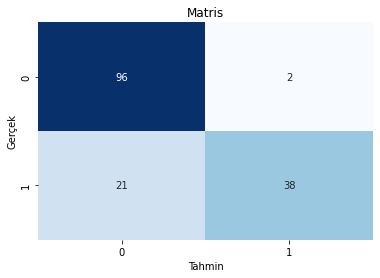

0.8535031847133758


In [12]:
from sklearn.metrics import confusion_matrix,accuracy_score
sns.heatmap(gnbcm,cmap="Blues",cbar=None,annot=True,fmt='.3g')
plt.title("Matris") #başlık 
plt.ylabel("Gerçek")# y ekseni başlığı 
plt.xlabel("Tahmin") # x ekseni başlığı 
plt.show()
print(accuracy_score(y_test,y_pred))  # (tp+tn)/(toplam)


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score

liste=[]
for i in range(1,11,2): 
        knn = KNeighborsClassifier(n_neighbors=i, metric="euclidean") 
        knn.fit(x_train_tfidf,y_train)
        y_pred = knn.predict(x_test_tfidf) 
        cm = confusion_matrix(y_test, y_pred)  
        x=(accuracy_score(y_test, y_pred))
        liste.append(cm)
        liste.append(x)
print(liste)

[array([[88, 10],
       [16, 43]]), 0.8343949044585988, array([[86, 12],
       [20, 39]]), 0.7961783439490446, array([[87, 11],
       [20, 39]]), 0.802547770700637, array([[92,  6],
       [21, 38]]), 0.8280254777070064, array([[89,  9],
       [22, 37]]), 0.802547770700637]


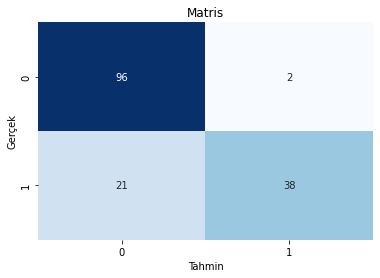

0.802547770700637


In [14]:
from sklearn.metrics import confusion_matrix,accuracy_score
sns.heatmap(gnbcm,cmap="Blues",cbar=None,annot=True,fmt='.3g')
plt.title("Matris") #başlık 
plt.ylabel("Gerçek")# y ekseni başlığı 
plt.xlabel("Tahmin") # x ekseni başlığı 
plt.show()
print(accuracy_score(y_test,y_pred))  # (tp+tn)/(toplam)

In [15]:
from sklearn.svm import SVC  
svc=SVC(kernel="rbf")        
svc=svc.fit(x_train_tfidf,y_train)
x_test_counts=cv.transform(x_test)
x_test_tfidf=tfidf_transformer.transform(x_test_counts).toarray()
y_pred=svc.predict(x_test_tfidf)   
svcskor=accuracy_score(y_test,y_pred)
svccm=confusion_matrix(y_test,y_pred)
print(svcskor)

0.8789808917197452


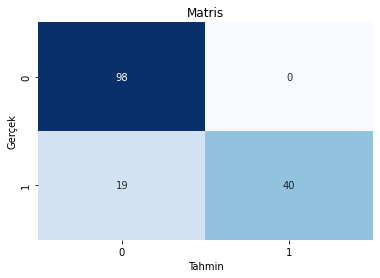

0.8789808917197452


In [16]:
from sklearn.metrics import confusion_matrix,accuracy_score
sns.heatmap(svccm,cmap="Blues",cbar=None,annot=True,fmt='.3g')
plt.title("Matris") #başlık 
plt.ylabel("Gerçek")# y ekseni başlığı 
plt.xlabel("Tahmin") # x ekseni başlığı 
plt.show()
print(accuracy_score(y_test,y_pred))  # (tp+tn)/(toplam)

In [17]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr=lr.fit(x_train_tfidf,y_train)
x_test_counts=cv.transform(x_test)
x_test_tfidf=tfidf_transformer.transform(x_test_counts).toarray()
y_pred = lr.predict(x_test_tfidf) 
lrskor=accuracy_score(y_test,y_pred)
lrcm=confusion_matrix(y_test,y_pred)
print(lrskor) 

0.8407643312101911


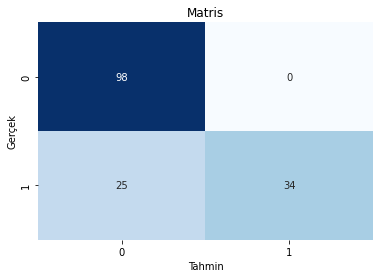

0.8407643312101911


In [18]:
from sklearn.metrics import confusion_matrix,accuracy_score
sns.heatmap(lrcm,cmap="Blues",cbar=None,annot=True,fmt='.3g')
plt.title("Matris") #başlık 
plt.ylabel("Gerçek")# y ekseni başlığı 
plt.xlabel("Tahmin") # x ekseni başlığı 
plt.show()
print(accuracy_score(y_test,y_pred))  # (tp+tn)/(toplam)


In [19]:
from xgboost import XGBClassifier
listee=[]
listee.append(f"Max Depth : 13")
xgb = XGBClassifier(eval_metric="rmse",max_depth=13)
xgb.fit(x_train_tfidf,y_train)
y_pred=xgb.predict(x_test_tfidf)
Xgbcm = confusion_matrix(y_test, y_pred) 
accuary_s=(accuracy_score(y_test, y_pred))
listee.append(Xgbcm)
listee.append(accuary_s) 
print( listee )

['Max Depth : 13', array([[94,  4],
       [10, 49]]), 0.910828025477707]


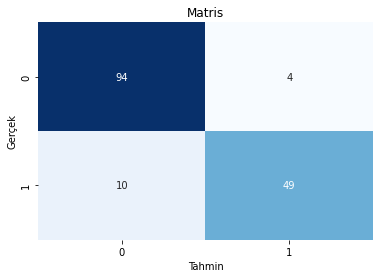

0.910828025477707


In [20]:
from sklearn.metrics import confusion_matrix,accuracy_score
sns.heatmap(Xgbcm,cmap="Blues",cbar=None,annot=True,fmt='.3g')
plt.title("Matris") #başlık 
plt.ylabel("Gerçek")# y ekseni başlığı 
plt.xlabel("Tahmin") # x ekseni başlığı 
plt.show()
print(accuracy_score(y_test,y_pred))  # (tp+tn)/(toplam)